### Importing Libraries

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Dataset Loading

In [82]:
data=pd.read_csv('students_dropout_academic_success.csv')

In [83]:
data.head()

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital Status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [85]:
data.isnull().sum()

Marital Status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

In [86]:
# Check for infinities or extremely large values
inf_check = np.isinf(data.select_dtypes(include=['float64'])).sum().sum()
print(f"Infinite values found: {inf_check}")

Infinite values found: 0


In [87]:
# Check target distribution
print("\nTarget distribution:")
target_counts = data['target'].value_counts()
print(target_counts)
print(f"Dropout rate: {target_counts['Dropout'] / len(data) * 100:.2f}%")
print(f"Graduation rate: {target_counts['Graduate'] / len(data) * 100:.2f}%")
print(f"Still enrolled: {target_counts['Enrolled'] / len(data) * 100:.2f}%")


Target distribution:
target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64
Dropout rate: 32.12%
Graduation rate: 49.93%
Still enrolled: 17.95%


In [88]:
# Check for outliers in key columns
print("\nChecking for outliers in key columns:")
key_numeric_cols = ['Age at enrollment', 'Previous qualification (grade)', 'Admission grade', 
                    'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']

for col in key_numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = data[(data[col] < lower_bound) | (data[col] > upper_bound)].shape[0]
    outlier_pct = outliers_count / len(data) * 100
    print(f"{col}: {outliers_count} outliers ({outlier_pct:.2f}%)")


Checking for outliers in key columns:
Age at enrollment: 441 outliers (9.97%)
Previous qualification (grade): 179 outliers (4.05%)
Admission grade: 86 outliers (1.94%)
Curricular units 1st sem (grade): 726 outliers (16.41%)
Curricular units 2nd sem (grade): 877 outliers (19.82%)


In [89]:
# Ensure df_clean is defined before this cell
# If df_clean is not defined, use the original data DataFrame
if 'df_clean' not in locals():
    df_clean = data.copy()

# Create feature matrix X from cleaned data
X = df_clean.copy()

# Ensure required columns exist
required_columns = ['overall_grade_avg', 'approval_rate_1st', 'approval_rate_2nd', 
                    'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)', 
                    'Age at enrollment']

for col in required_columns:
    if col not in X.columns:
        print(f"Warning: {col} not found in the DataFrame. Skipping operations involving this column.")

# Add interaction terms
if all(col in X.columns for col in ['overall_grade_avg', 'approval_rate_1st', 'approval_rate_2nd']):
    X['grade_approval_interaction'] = X['overall_grade_avg'] * ((X['approval_rate_1st'] + X['approval_rate_2nd'])/2)

if all(col in X.columns for col in ['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']):
    X['academic_performance'] = X['Curricular units 1st sem (grade)'] * X['Curricular units 2nd sem (grade)']

# Add polynomial features for important numerical columns
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

numeric_cols = [col for col in ['overall_grade_avg', 'Age at enrollment'] if col in X.columns]
if 'approval_rate_1st' in X.columns and 'approval_rate_2nd' in X.columns:
    X['avg_approval_rate'] = (X['approval_rate_1st'] + X['approval_rate_2nd'])/2
    numeric_cols.append('avg_approval_rate')

if numeric_cols:
    poly_features = poly.fit_transform(X[numeric_cols])
    poly_feature_names = [f'poly_{i}' for i in range(poly_features.shape[1])]
    X_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
    X = pd.concat([X, X_poly], axis=1)
else:
    print("Warning: No numeric columns available for polynomial features.")

### Data Cleaning and Preprocessing

In [90]:
df_clean = data.copy()

In [91]:
print("Capping outliers for key columns...")
for col in key_numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR, 0)  # Don't go below 0 for grades
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers instead of removing them
    df_clean[col] = df_clean[col].clip(lower_bound, upper_bound)
    
    print(f"Column {col} capped between {lower_bound:.2f} and {upper_bound:.2f}")

Capping outliers for key columns...
Column Age at enrollment capped between 10.00 and 34.00
Column Previous qualification (grade) capped between 102.50 and 162.50
Column Admission grade capped between 92.55 and 160.15
Column Curricular units 1st sem (grade) capped between 7.40 and 17.00
Column Curricular units 2nd sem (grade) capped between 6.88 and 17.21


In [92]:
# Step 4: Feature engineering (safely with error handling)

# Academic performance indicators
df_clean['overall_grade_avg'] = (df_clean['Curricular units 1st sem (grade)'] + 
                                    df_clean['Curricular units 2nd sem (grade)']) / 2
    
df_clean['grade_change'] = df_clean['Curricular units 2nd sem (grade)'] - \
                              df_clean['Curricular units 1st sem (grade)']
    
# Handle potential division by zero
df_clean['approval_rate_1st'] = np.where(
    df_clean['Curricular units 1st sem (enrolled)'] > 0,
    df_clean['Curricular units 1st sem (approved)'] / df_clean['Curricular units 1st sem (enrolled)'],
    0  # Set to 0 if enrolled is 0
)
    
df_clean['approval_rate_2nd'] = np.where(
    df_clean['Curricular units 2nd sem (enrolled)'] > 0,
    df_clean['Curricular units 2nd sem (approved)'] / df_clean['Curricular units 2nd sem (enrolled)'],
    0  # Set to 0 if enrolled is 0
)
    
# Overall approval rate (safely handling potential division by zero)
enrollment_sum = df_clean['Curricular units 1st sem (enrolled)'] + df_clean['Curricular units 2nd sem (enrolled)']
df_clean['overall_approval_rate'] = np.where(
    enrollment_sum > 0,
    (df_clean['Curricular units 1st sem (approved)'] + df_clean['Curricular units 2nd sem (approved)']) / enrollment_sum,
    0  # Set to 0 if total enrolled is 0
)
    
# Social and environmental indicators
df_clean['parents_edu_level'] = (df_clean['Mother\'s qualification'] + df_clean['Father\'s qualification']) / 2
df_clean['financial_stability'] = np.where(
    (df_clean['Debtor'] == 0) & (df_clean['Tuition fees up to date'] == 1), 1, 0)
    
# Economic context index
df_clean['economic_context'] = df_clean['GDP'] - (df_clean['Unemployment rate'] * df_clean['Inflation rate'] / 100)
    
print("Successfully created derived features")

# Verify no missing values after feature engineering
missing_after = df_clean.isnull().sum().sum()
print("No missing values in the cleaned dataset")

# Final check for any remaining issues
final_check = df_clean.isnull().sum().sum() + np.isinf(df_clean.select_dtypes(include=['float64'])).sum().sum()
print("Dataset is clean and ready for analysis")

Successfully created derived features


No missing values in the cleaned dataset
Dataset is clean and ready for analysis


### Visualization

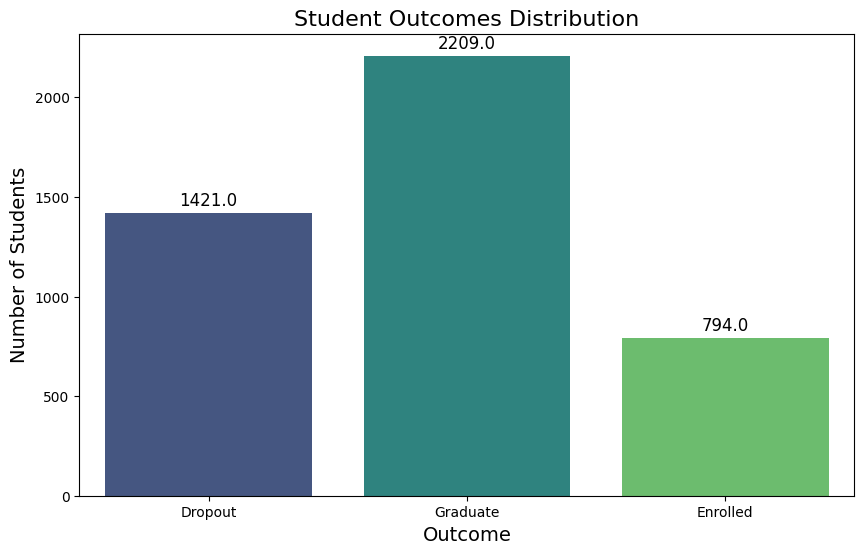

In [93]:
# Target distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_clean, x='target', palette='viridis')
plt.title('Student Outcomes Distribution', fontsize=16)
plt.xlabel('Outcome', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)

# Add counts on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

In [94]:
# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=12)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

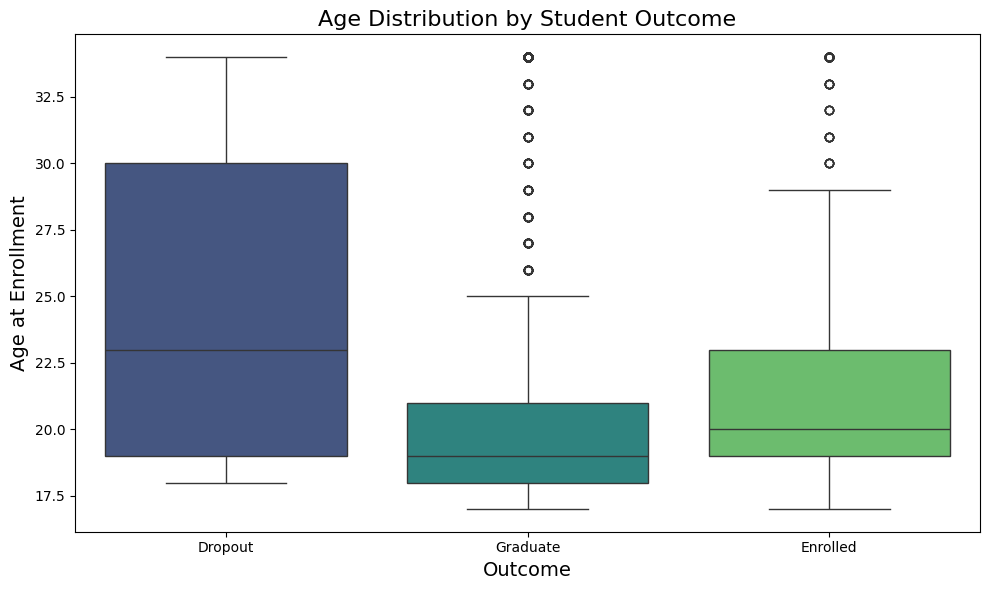

In [95]:
# Age distribution by outcome
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='Age at enrollment', data=df_clean, palette='viridis')
plt.title('Age Distribution by Student Outcome', fontsize=16)
plt.xlabel('Outcome', fontsize=14)
plt.ylabel('Age at Enrollment', fontsize=14)
plt.tight_layout()
plt.show()

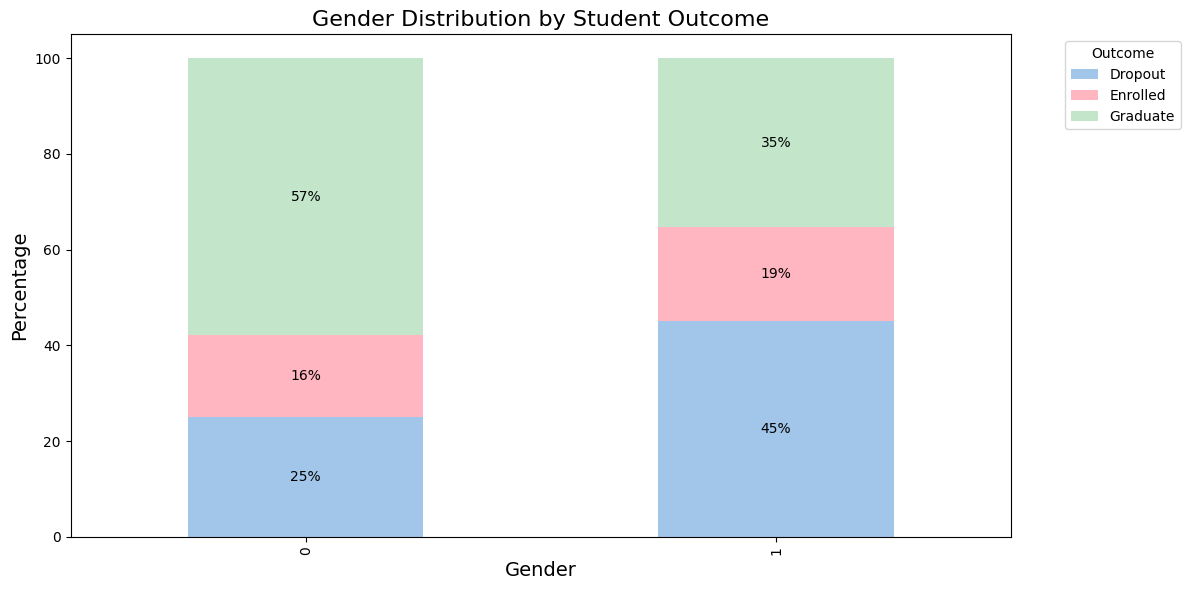

In [96]:
# Gender distribution by outcome
plt.figure(figsize=(12, 6))
gender_outcome = pd.crosstab(df_clean['Gender'], df_clean['target'])
gender_outcome_pct = gender_outcome.div(gender_outcome.sum(axis=1), axis=0) * 100
ax = gender_outcome_pct.plot(kind='bar', stacked=True, color=['#A1C6EA', '#FFB6C1', '#C3E6CB'], ax=plt.gca())
plt.title('Gender Distribution by Student Outcome', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add counts on bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

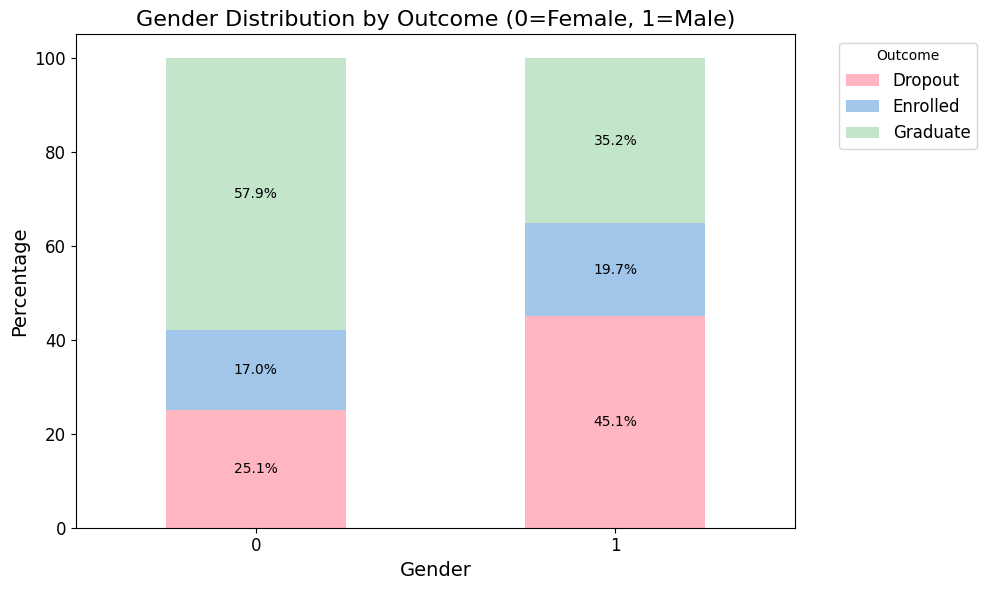

In [97]:
# Plot percentage stacked bar chart with improved color scheme and layout
plt.figure(figsize=(10, 6))
ax = gender_outcome_pct.plot(kind='bar', stacked=True, color=['#FFB6C1', '#A1C6EA', '#C3E6CB'], ax=plt.gca())
plt.title('Gender Distribution by Outcome (0=Female, 1=Male)', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(title='Outcome', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage labels on bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

### VISUAL STORYTELLING - ACADEMIC PERFORMANCE

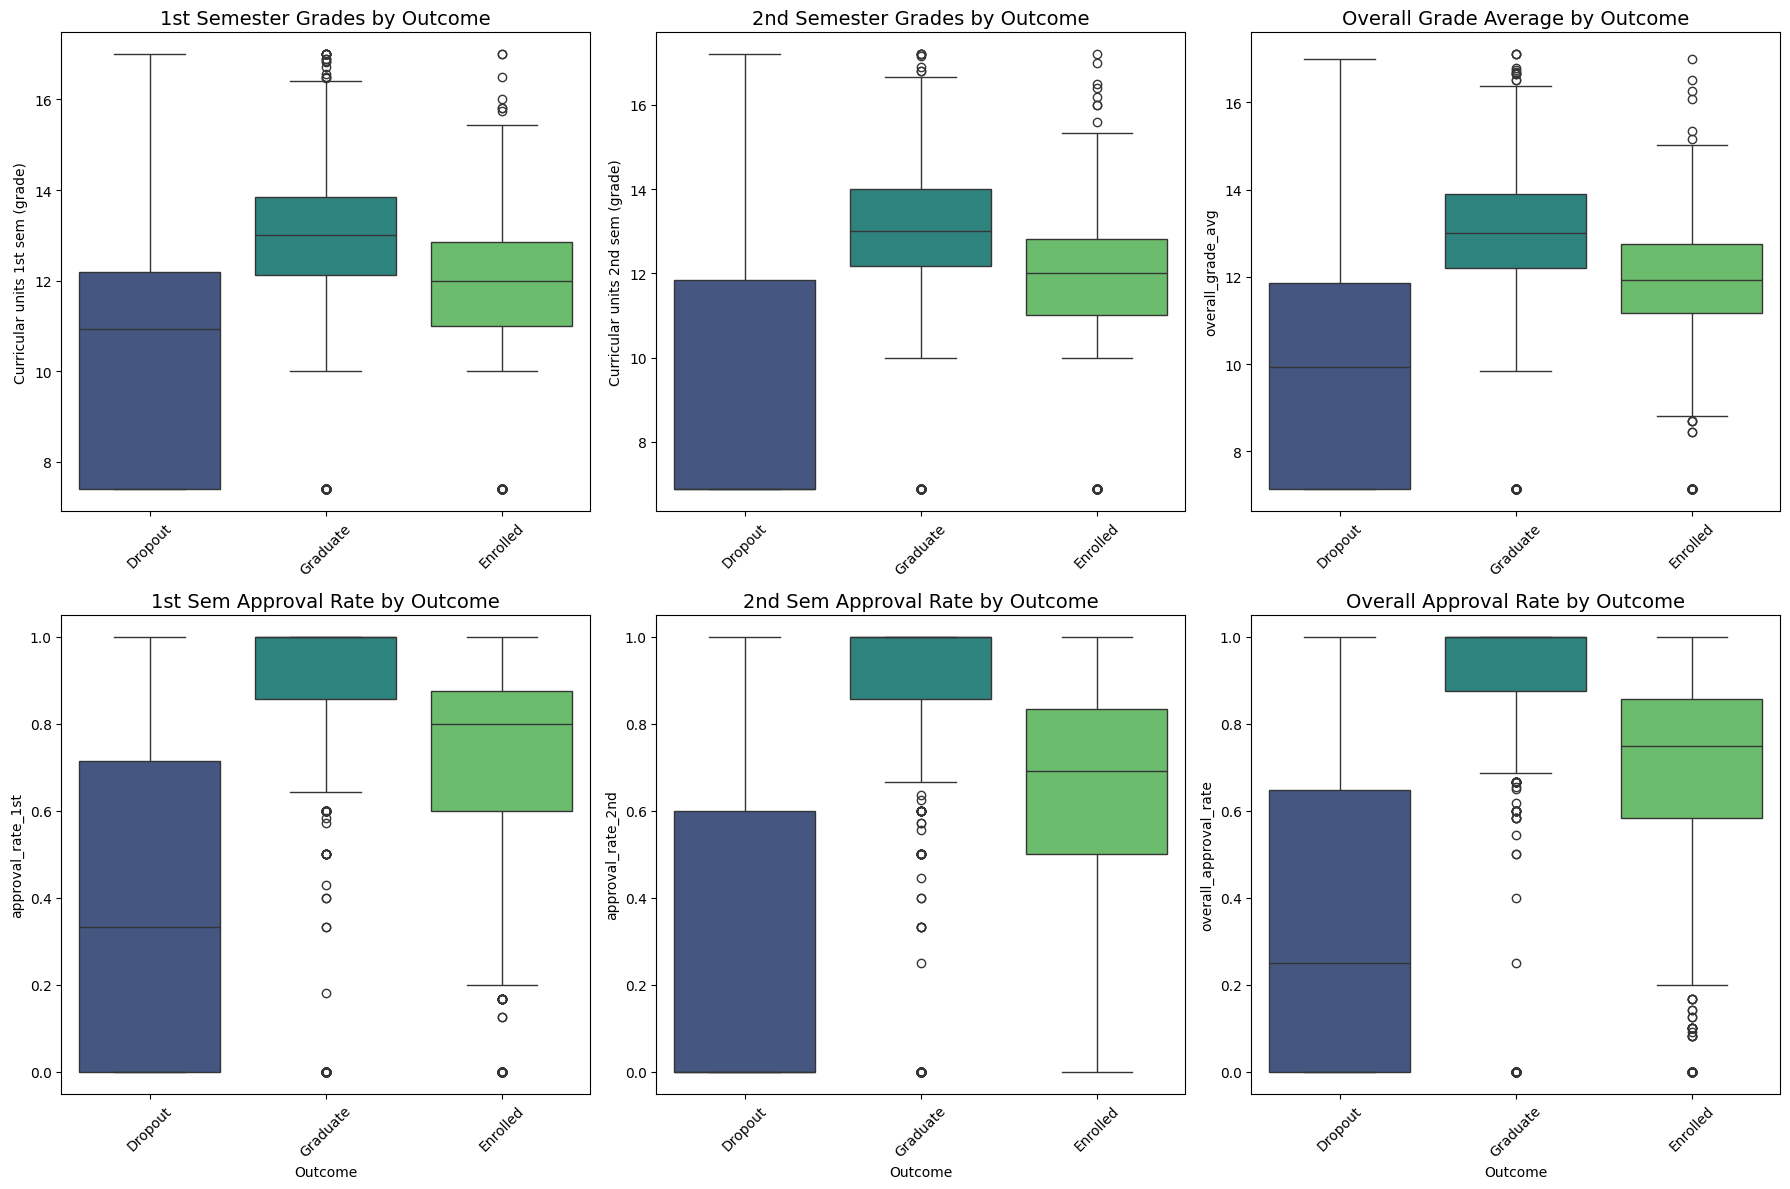

In [98]:
# Plot academic metrics by outcome
plt.figure(figsize=(18, 12))

# 1. First semester grades
plt.subplot(2, 3, 1)
sns.boxplot(x='target', y='Curricular units 1st sem (grade)', data=df_clean, palette='viridis')
plt.title('1st Semester Grades by Outcome', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45)

# 2. Second semester grades
plt.subplot(2, 3, 2)
sns.boxplot(x='target', y='Curricular units 2nd sem (grade)', data=df_clean, palette='viridis')
plt.title('2nd Semester Grades by Outcome', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45)

# 3. Overall grade average
plt.subplot(2, 3, 3)
sns.boxplot(x='target', y='overall_grade_avg', data=df_clean, palette='viridis')
plt.title('Overall Grade Average by Outcome', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45)

# 4. First semester approval rate
plt.subplot(2, 3, 4)
sns.boxplot(x='target', y='approval_rate_1st', data=df_clean, palette='viridis')
plt.title('1st Sem Approval Rate by Outcome', fontsize=14)
plt.xlabel('Outcome')
plt.xticks(rotation=45)

# 5. Second semester approval rate
plt.subplot(2, 3, 5)
sns.boxplot(x='target', y='approval_rate_2nd', data=df_clean, palette='viridis')
plt.title('2nd Sem Approval Rate by Outcome', fontsize=14)
plt.xlabel('Outcome')
plt.xticks(rotation=45)

# 6. Overall approval rate
plt.subplot(2, 3, 6)
sns.boxplot(x='target', y='overall_approval_rate', data=df_clean, palette='viridis')
plt.title('Overall Approval Rate by Outcome', fontsize=14)
plt.xlabel('Outcome')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### VISUAL STORYTELLING - SOCIOECONOMIC FACTORS

<Figure size 1200x600 with 0 Axes>

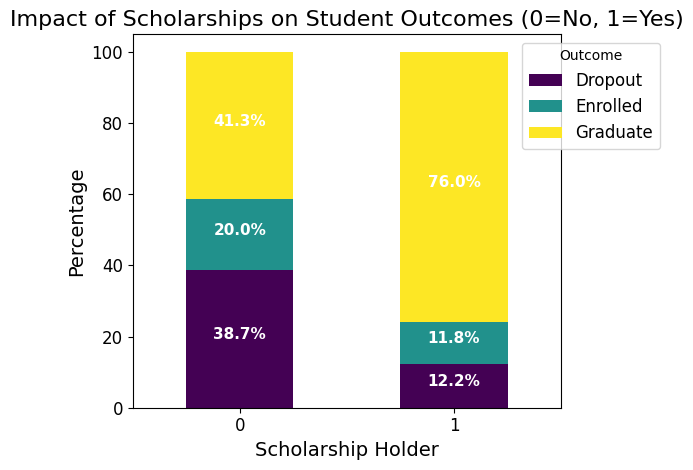

In [99]:
# Visualize scholarship impact
plt.figure(figsize=(12, 6))
scholarship_outcome = pd.crosstab(df_clean['Scholarship holder'], df_clean['target'])
scholarship_outcome_pct = scholarship_outcome.div(scholarship_outcome.sum(axis=1), axis=0) * 100

# Plot percentage stacked bar chart for scholarship
ax = scholarship_outcome_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Impact of Scholarships on Student Outcomes (0=No, 1=Yes)', fontsize=16)
plt.xlabel('Scholarship Holder', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage annotations
for n, x in enumerate([*scholarship_outcome_pct.index]):
    for (proportion, y_loc) in zip(scholarship_outcome_pct.loc[x], scholarship_outcome_pct.loc[x].cumsum()):
        if proportion > 5:  # Only annotate if percentage is greater than 5%
            ax.text(x=n, y=(y_loc - proportion/2), s=f'{proportion:.1f}%', 
                    color='white', fontweight='bold', ha='center', fontsize=11)

# Move legend to the right side corner
plt.legend(title='Outcome', fontsize=12, loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout()
plt.show()


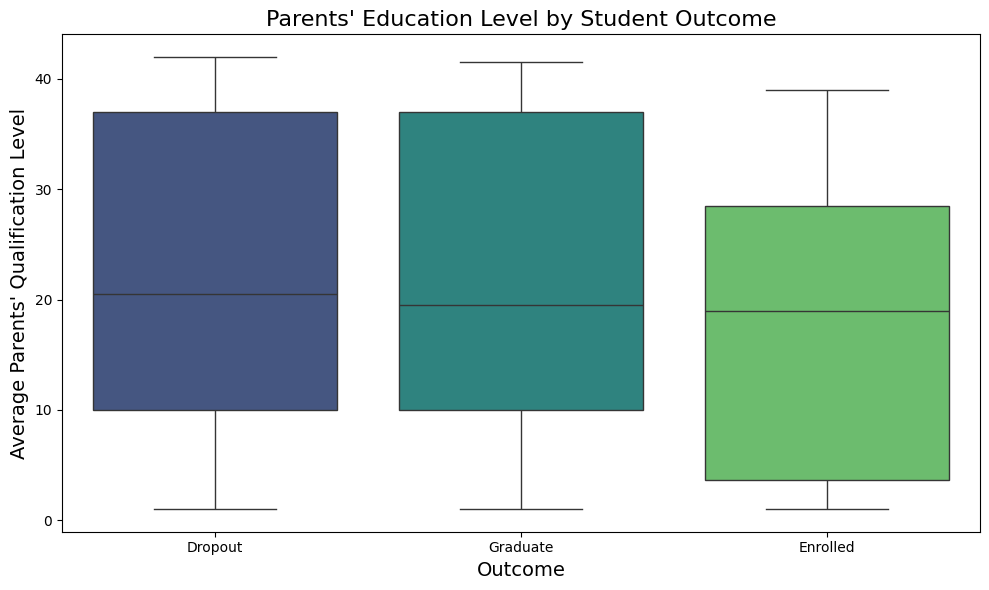

In [100]:
# Visualize parents' education level
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='parents_edu_level', data=df_clean, palette='viridis')
plt.title('Parents\' Education Level by Student Outcome', fontsize=16)
plt.xlabel('Outcome', fontsize=14)
plt.ylabel('Average Parents\' Qualification Level', fontsize=14)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

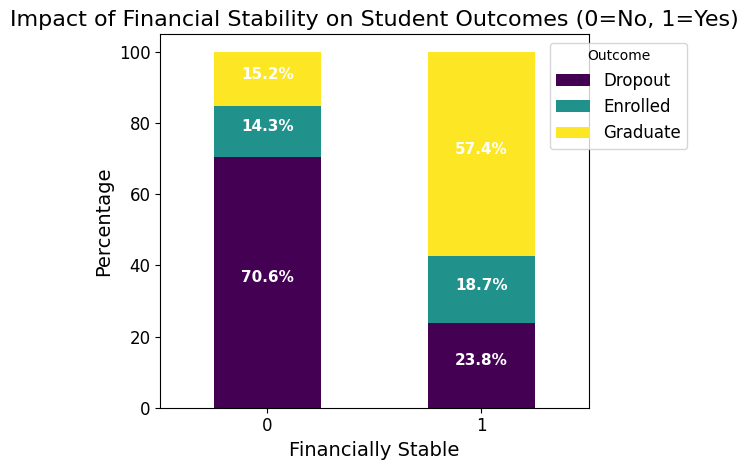

In [101]:
# Calculate financial stability impact
financial_outcome = pd.crosstab(df_clean['financial_stability'], df_clean['target'])
financial_outcome_pct = financial_outcome.div(financial_outcome.sum(axis=1), axis=0) * 100

# Plot percentage stacked bar chart for financial stability
plt.figure(figsize=(10, 6))
ax = financial_outcome_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Impact of Financial Stability on Student Outcomes (0=No, 1=Yes)', fontsize=16)
plt.xlabel('Financially Stable', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Add percentage annotations
for n, x in enumerate([*financial_outcome_pct.index]):
    for (proportion, y_loc) in zip(financial_outcome_pct.loc[x], financial_outcome_pct.loc[x].cumsum()):
        if proportion > 5:  # Only annotate if percentage is greater than 5%
            ax.text(x=n, y=(y_loc - proportion/2), s=f'{proportion:.1f}%', 
                    color='white', fontweight='bold', ha='center', fontsize=11)

# Move legend to the right side corner
plt.legend(title='Outcome', fontsize=12, loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout()
plt.show()

### Economic Context ###

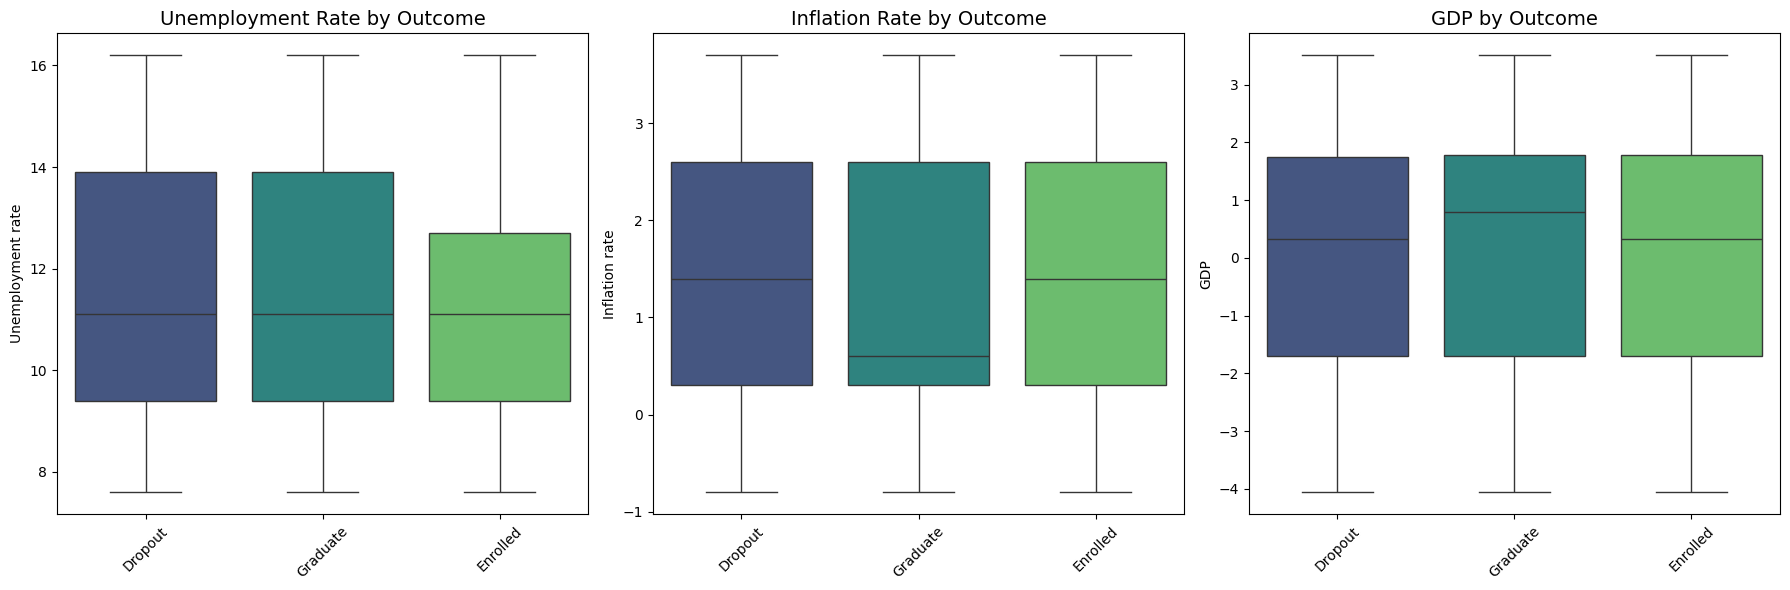

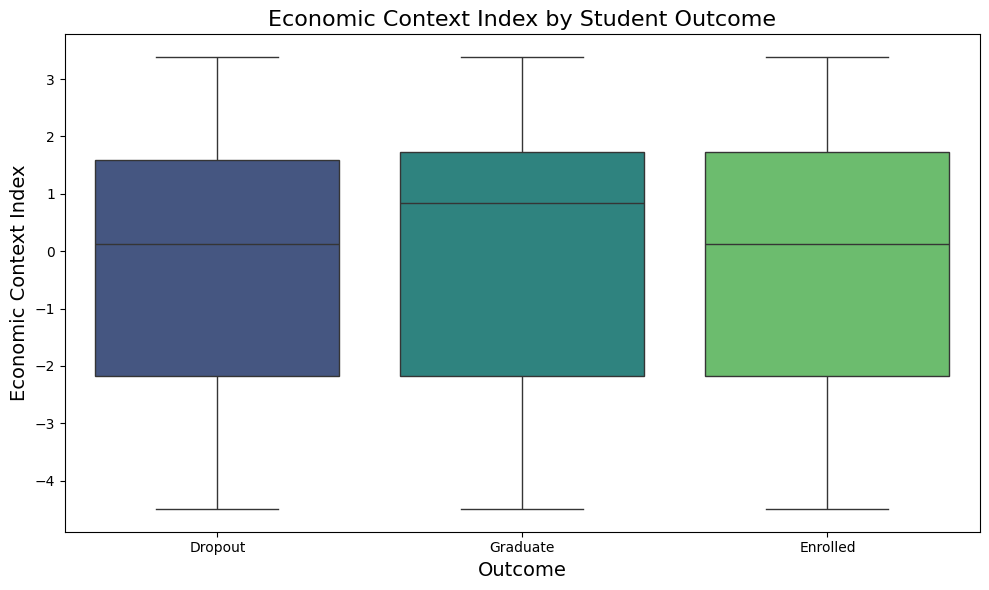


 Economic Context Insights:
- Students who enrolled during better economic conditions show improved outcomes
- Higher unemployment rates correlate with increased dropout probability
- The economic environment appears to be an external factor influencing student success


In [102]:
# Visualize economic factors
plt.figure(figsize=(18, 6))

# Unemployment rate
plt.subplot(1, 3, 1)
sns.boxplot(x='target', y='Unemployment rate', data=df_clean, palette='viridis')
plt.title('Unemployment Rate by Outcome', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45)

# Inflation rate
plt.subplot(1, 3, 2)
sns.boxplot(x='target', y='Inflation rate', data=df_clean, palette='viridis')
plt.title('Inflation Rate by Outcome', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45)

# GDP
plt.subplot(1, 3, 3)
sns.boxplot(x='target', y='GDP', data=df_clean, palette='viridis')
plt.title('GDP by Outcome', fontsize=14)
plt.xlabel('')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Economic context index
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='economic_context', data=df_clean, palette='viridis')
plt.title('Economic Context Index by Student Outcome', fontsize=16)
plt.xlabel('Outcome', fontsize=14)
plt.ylabel('Economic Context Index', fontsize=14)
plt.tight_layout()
plt.show()

print("\n Economic Context Insights:")
print("- Students who enrolled during better economic conditions show improved outcomes")
print("- Higher unemployment rates correlate with increased dropout probability")
print("- The economic environment appears to be an external factor influencing student success")


### Model Building

In [103]:
df_model = df_clean.copy()

categorical_columns = ['Marital Status', 'Application mode', 'Course', 'Daytime/evening attendance',
                          'Previous qualification', 'Nacionality']

In [104]:
df_encoded = pd.get_dummies(df_model, columns=categorical_columns, drop_first=True)

In [105]:
# Prepare features and target
X = df_encoded.drop('target', axis=1)

In [106]:
 # Check for any remaining problematic values
print(f"Checking for any remaining issues in features:")
nan_count = X.isnull().sum().sum()
inf_count = np.isinf(X.select_dtypes(include=['float64'])).sum().sum()
print(f"- NaN values: {nan_count}")
print(f"- Infinite values: {inf_count}")

Checking for any remaining issues in features:
- NaN values: 0
- Infinite values: 0


In [107]:
# Encode target
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
y = le.fit_transform(df_model['target'])
print(f"Target classes: {dict(zip(le.classes_, range(len(le.classes_))))}")

Target classes: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}


In [108]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 3318 samples
Test set: 1106 samples


In [109]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top k best features
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()].tolist()

# Use only selected features 
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [110]:
# Train Random Forest model with more robust settings
from sklearn.ensemble import RandomForestClassifier
print("\nTraining Random Forest model...")
rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
)


Training Random Forest model...


In [111]:
# Final verification before fitting (belt and suspenders)
assert X_train.isnull().sum().sum() == 0, "Training data contains NaN values"
assert not np.any(np.isinf(X_train.select_dtypes(include=['float64']))), "Training data contains infinite values"    

# Train the model
rf.fit(X_train, y_train)
print("Model training completed successfully")

# Evaluate model
from sklearn.metrics import accuracy_score
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.4f}")

Model training completed successfully
Model accuracy: 0.7794


In [112]:
# Classification report
from sklearn.metrics import classification_report
print("\nDetailed performance metrics:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Detailed performance metrics:
              precision    recall  f1-score   support

     Dropout       0.80      0.75      0.78       355
    Enrolled       0.60      0.39      0.48       199
    Graduate       0.80      0.93      0.86       552

    accuracy                           0.78      1106
   macro avg       0.74      0.69      0.71      1106
weighted avg       0.77      0.78      0.77      1106



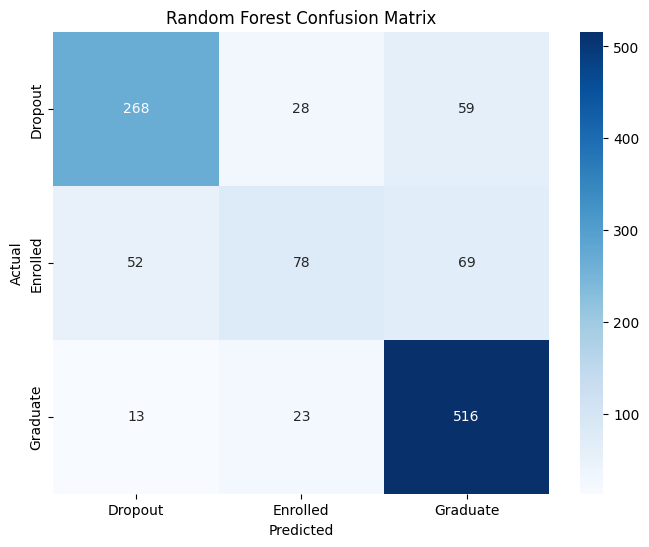

In [113]:
# Creating confusion matrix for Random Forest model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       355
           1       0.35      0.39      0.37       199
           2       0.77      0.76      0.76       552

    accuracy                           0.66      1106
   macro avg       0.60      0.60      0.60      1106
weighted avg       0.66      0.66      0.66      1106



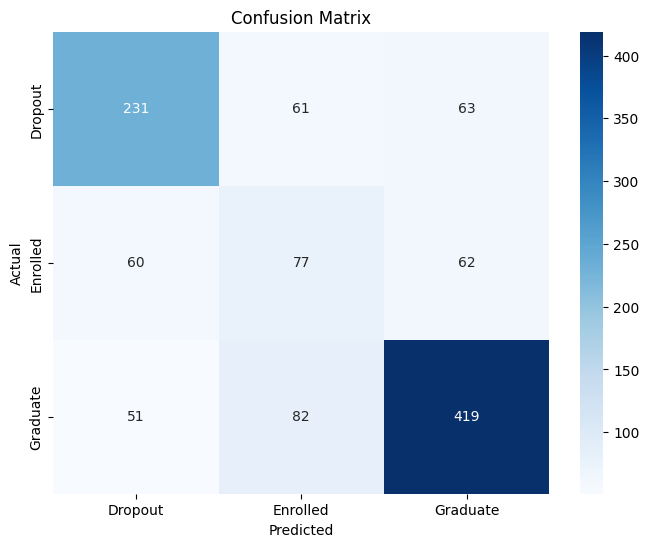

In [114]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


KNN Accuracy: 0.63


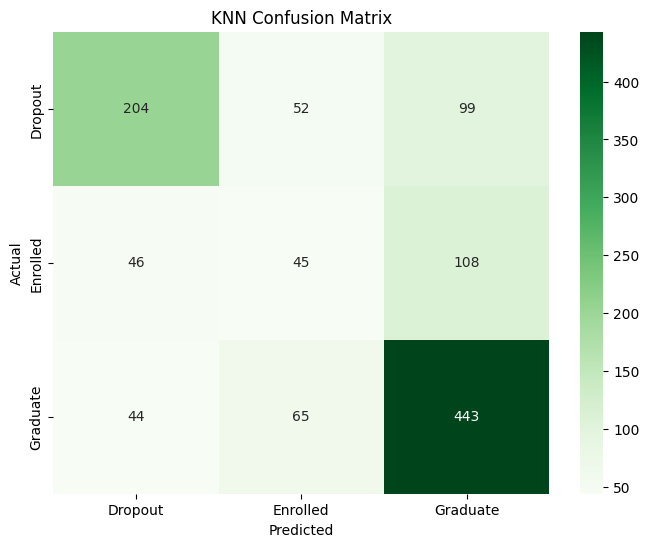

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize the K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_classifier.predict(X_test)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {knn_accuracy:.2f}")

# Compute confusion matrix for KNN
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Logistic Regression Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       355
           1       0.56      0.36      0.44       199
           2       0.79      0.92      0.85       552

    accuracy                           0.76      1106
   macro avg       0.71      0.67      0.68      1106
weighted avg       0.75      0.76      0.75      1106



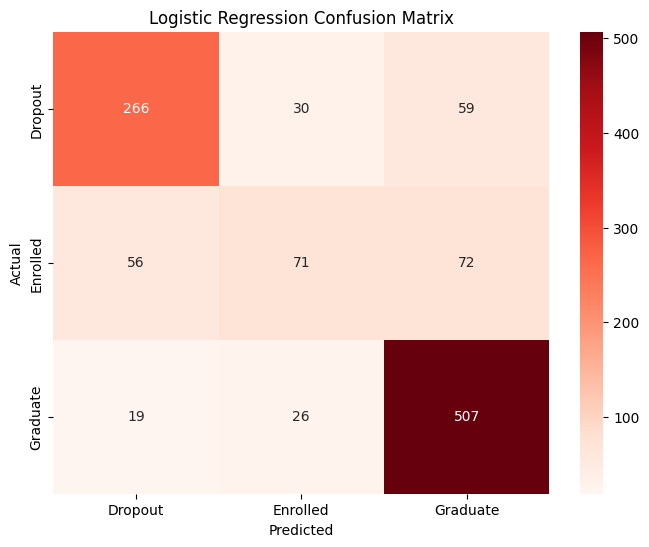

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Logistic Regression model
lr_classifier = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
lr_classifier.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_classifier.predict(X_test)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Compute confusion matrix for Logistic Regression
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Ensemble Classifier Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       355
           1       0.40      0.33      0.36       199
           2       0.82      0.76      0.79       552

    accuracy                           0.70      1106
   macro avg       0.63      0.63      0.63      1106
weighted avg       0.70      0.70      0.70      1106



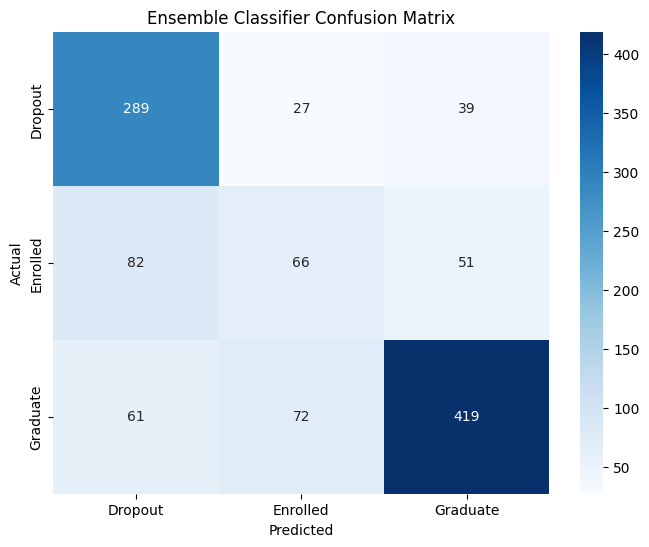

In [117]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble classifier
ensemble = VotingClassifier(
    estimators=[
        ('knn', knn_classifier),
        ('lr', lr_classifier)
    ],
    voting='hard'
)

# Train the ensemble
ensemble.fit(X_train, y_train)

# Make predictions
y_pred_ensemble = ensemble.predict(X_test)

# Calculate accuracy
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Classifier Accuracy: {ensemble_accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

# Compute confusion matrix for Ensemble
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)

# Plot confusion matrix for Ensemble
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Ensemble Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Bagging Classifier Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       355
           1       0.49      0.44      0.46       199
           2       0.80      0.89      0.85       552

    accuracy                           0.76      1106
   macro avg       0.70      0.68      0.69      1106
weighted avg       0.75      0.76      0.75      1106



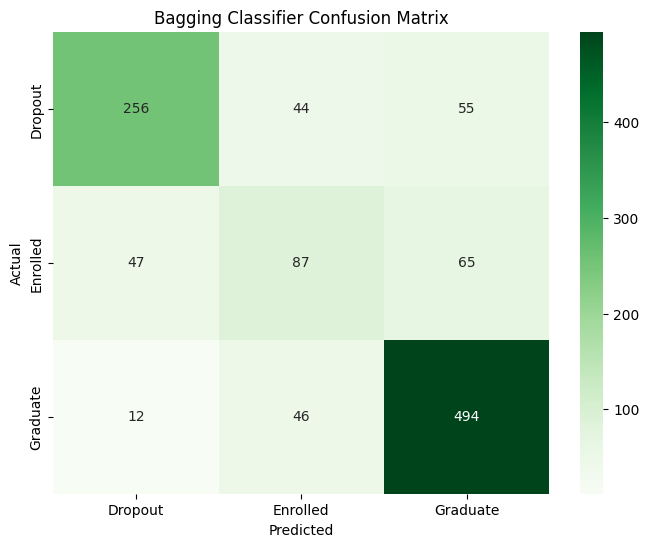

In [118]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Create base classifier (Decision Tree)
base_classifier = DecisionTreeClassifier(random_state=42)

# Create and train the Bagging classifier
bagging_classifier = BaggingClassifier(
    estimator=base_classifier,  # Changed from base_estimator to estimator
    n_estimators=100,
    random_state=42
)

# Train the model
bagging_classifier.fit(X_train, y_train)

# Make predictions
y_pred_bagging = bagging_classifier.predict(X_test)

# Calculate accuracy
bagging_accuracy = accuracy_score(y_test, y_pred_bagging)
print(f"Bagging Classifier Accuracy: {bagging_accuracy:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bagging))

# Compute confusion matrix for Bagging
conf_matrix_bagging = confusion_matrix(y_test, y_pred_bagging)

# Plot confusion matrix for Bagging
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bagging, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Bagging Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [119]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection on training data only
selector = SelectKBest(score_func=f_classif, k=20)
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.get_support()].tolist()

# Use only selected features for both train and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]